In [22]:
!conda activate cvxpy
!pip install cvxpy
!pip install PyPortfolioOpt


C:\Projects\vrs_project>set "JAVA_HOME="  


In [23]:
import utilities as ut
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypfopt
from pypfopt import risk_models, expected_returns, plotting
pypfopt.__version__

'1.2.6'

In [24]:
def combine_portfolio(data):
    import pandas as pd
    result = pd.DataFrame([])
    for series in data:
        series.index.rename('Date', inplace=True)
        series = series.pct_change()
        if result.empty == True:
            result = series
        else:
            result = pd.merge(result, series, how='inner', on='Date')     
    return result   

raw_data = ut.clean_data()
portfolio = combine_portfolio(raw_data)

print(portfolio.tail())

              asset1    asset2    asset3    asset4    asset5    asset6  \
Date                                                                     
2020-07-17  0.001853 -0.000483 -0.001352  0.003223  0.001482  0.008238   
2020-07-20  0.001367  0.001126  0.000592  0.001645  0.004947  0.004820   
2020-07-21  0.002248  0.001482  0.000599  0.007092  0.005970  0.012051   
2020-07-22  0.000000  0.001060  0.000973 -0.003275  0.002652  0.015202   
2020-07-23 -0.000080  0.000000  0.000000 -0.014211  0.000000  0.012128   

              asset7    asset8    asset9   asset10  
Date                                                
2020-07-17  0.002899 -0.001352  0.008870 -0.002058  
2020-07-20  0.008082  0.000592  0.010071  0.000687  
2020-07-21  0.002128  0.000599 -0.002453  0.020604  
2020-07-22  0.005692  0.000973  0.020704  0.001009  
2020-07-23 -0.006853  0.000000  0.000047 -0.005546  


# Comparing covariance from 2005-2018 to 2019-2020 - do the same relationships hold?

- For the most part, yes. Uncorrelated assets appear more correlated in 2019-2020, but overall relationships appear to hold. 

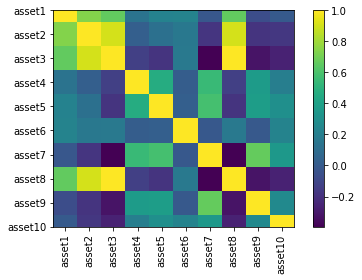

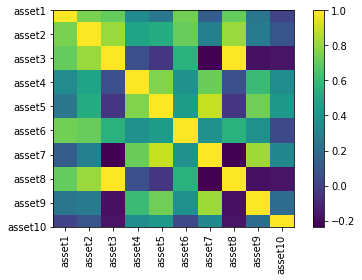

In [25]:
# Shows that past in-sample covariance of returns calculations are pretty good estimators of future covariance

past_return_covariance = risk_models.sample_cov(portfolio.loc['2005': '2018'].resample('W').mean().dropna(), returns_data=True, frequency=252)
future_return_covariance = risk_models.sample_cov(portfolio.loc['2019': '2020'].resample('W').mean().dropna(), returns_data=True, frequency=252)

plotting.plot_covariance(past_return_covariance, plot_correlation=True)
plotting.plot_covariance(future_return_covariance, plot_correlation=True)
plt.show()

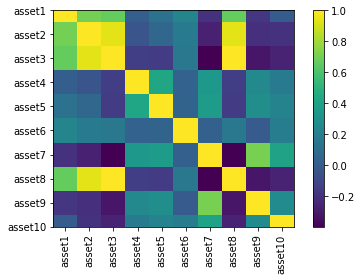

In [26]:
sample_cov = risk_models.sample_cov(portfolio, returns_data=True, frequency=252)
plotting.plot_covariance(sample_cov, plot_correlation=True)
plt.show()

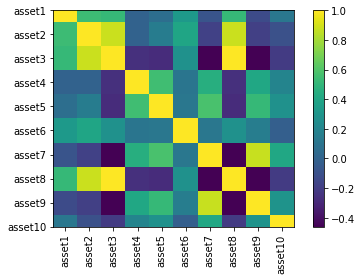

In [27]:
S = risk_models.risk_matrix(portfolio, returns_data=True, method='exp_cov')
plotting.plot_covariance(S, plot_correlation=True)
plt.show()

# Applying the Ledoit-Wolf Covariance Shrinkage Transformation to reduce effects of outliers on weights

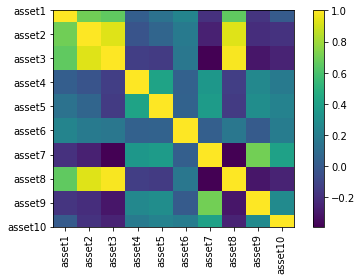

In [28]:
V = risk_models.CovarianceShrinkage(portfolio, returns_data=True, frequency=252).ledoit_wolf(shrinkage_target='constant_correlation')

plotting.plot_covariance(V, plot_correlation=True)

plt.show()

# Calculating Exponentially Weighted Historical Returns to Estimate E(R)

asset1     0.072789
asset2     0.087107
asset3     0.089704
asset4     0.001691
asset5     0.080612
asset6     0.282086
asset7     0.169779
asset8     0.089704
asset9     0.030843
asset10   -0.444381
Name: 2020-07-23 00:00:00, dtype: float64


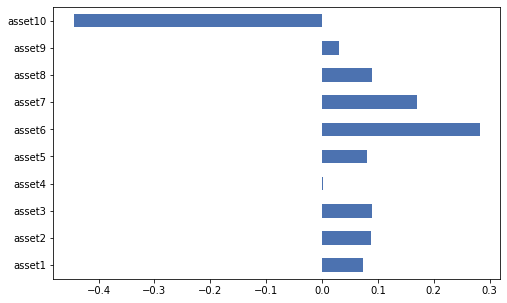

In [29]:
from pypfopt import expected_returns

mu = expected_returns.ema_historical_return(portfolio, returns_data=True, frequency=252)

print(mu)

mu.plot.barh(figsize=(8, 5))

# Deriving and Visualizing Weights for a Maximized Sharpe and Minimized Volatility Portfolio

Expected annual return: 10.6%
Annual volatility: 3.3%
Sharpe Ratio: 2.62


(0.10630270205066505, 0.032954275160263, 2.6188620939455762)

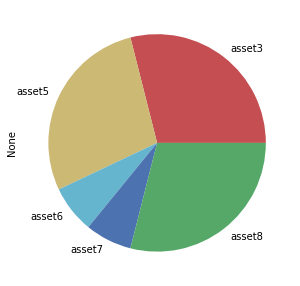

In [30]:
from pypfopt import EfficientFrontier

ef = EfficientFrontier(mu, V, weight_bounds=(0, 1))
ef.max_sharpe()
cleaned_weights = ef.clean_weights()
pd.Series(cleaned_weights).plot.pie(figsize=(5, 5))
ef.save_weights_to_file('weights/max_sharpe_weights.csv')
ef.portfolio_performance(verbose=True)

Expected annual return: 8.5%
Annual volatility: 2.9%
Sharpe Ratio: 2.21


(0.08453664336186001, 0.029157365397301373, 2.213390767048971)

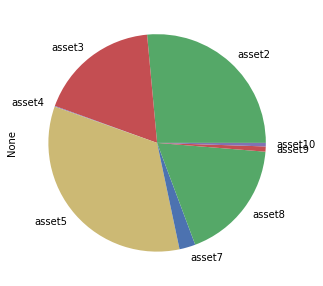

In [31]:
alternate_ef = EfficientFrontier(mu, V, weight_bounds=(0, 1))
alternate_ef.min_volatility()
cleaned_weights = alternate_ef.clean_weights()
pd.Series(cleaned_weights).plot.pie(figsize=(5, 5))
alternate_ef.save_weights_to_file('weights/min_vol_weights.csv')
alternate_ef.portfolio_performance(verbose=True)

# Placing each portfolio on the Efficient Frontier

Expected annual return: 8.5%
Annual volatility: 2.9%
Sharpe Ratio: 2.21


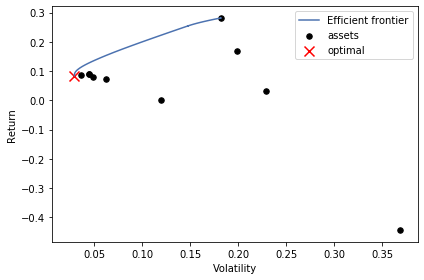

In [32]:
from pypfopt import CLA, plotting

cla_min_vol = CLA(mu, V)
cla_min_vol.min_volatility()
cla_min_vol.portfolio_performance(verbose=True)
ax_1 = plotting.plot_efficient_frontier(cla_min_vol, showfig=False)

Expected annual return: 10.2%
Annual volatility: 3.2%
Sharpe Ratio: 2.61


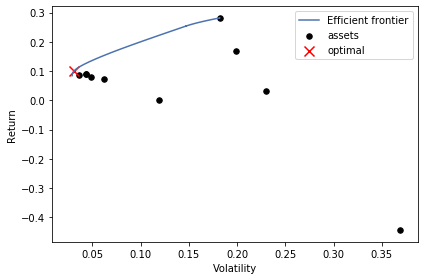

In [33]:
cla_max_sharpe = CLA(mu, V)
cla_max_sharpe.max_sharpe()
cla_max_sharpe.portfolio_performance(verbose=True)
ax_2 = plotting.plot_efficient_frontier(cla_max_sharpe, showfig=False)